# LOPF then non-linear power flow with SciGRID

This Jupyter Notebook is also available to download at: <http://www.pypsa.org/examples/scigrid-lopf-then-pf.ipynb> and can be viewed as an HTML page at: <http://pypsa.org/examples/scigrid-lopf-then-pf.html>.

In this example, the dispatch of generators is optimised using the linear OPF, then a non-linear power flow is run on the resulting dispatch.

The data files for this example are in the examples folder of the github repository: <https://github.com/PyPSA/PyPSA>.

## Data sources

Grid: based on [SciGRID](http://scigrid.de/) Version 0.2 which is based on [OpenStreetMap](http://www.openstreetmap.org/).

Load size and location: based on Landkreise (NUTS 3) GDP and population.

Load time series: from ENTSO-E hourly data, scaled up uniformly by factor 1.12 (a simplification of the methodology in Schumacher, Hirth (2015)).

Conventional power plant capacities and locations: BNetzA list.

Wind and solar capacities and locations: EEG Stammdaten, based on  http://www.energymap.info/download.html, which represents capacities at the end of 2014. Units without PLZ are removed.

Wind and solar time series: REatlas, Andresen et al, "Validation of Danish wind time series from a new global renewable energy atlas for energy system analysis," Energy 93 (2015) 1074 - 1088.

NB:

All times in the dataset are UTC.

Where SciGRID nodes have been split into 220kV and 380kV substations, all load and generation is attached to the 220kV substation.

## Warnings

This script and the data behind it are no longer supported. See https://github.com/PyPSA/pypsa-eur for a newer model that covers the whole of Europe.

This dataset is ONLY intended to demonstrate the capabilities of PyPSA and is NOT (yet) accurate enough to be used for research purposes.

Known problems include:

i) Rough approximations have been made for missing grid data, e.g. 220kV-380kV transformers and connections between close sub-stations missing from OSM.

ii) There appears to be some unexpected congestion in parts of the network, which may mean for example that the load attachment method (by Voronoi cell overlap with Landkreise) isn't working, particularly in regions with a high density of substations.

iii) Attaching power plants to the nearest high voltage substation may not reflect reality.

iv) There is no proper n-1 security in the calculations - this can either be simulated with a blanket e.g. 70% reduction in thermal limits (as done here) or a proper security constrained OPF (see e.g.  <http://www.pypsa.org/examples/scigrid-sclopf.ipynb>).

v) The borders and neighbouring countries are not represented.

vi) Hydroelectric power stations are not modelled accurately.

viii) The marginal costs are illustrative, not accurate.

ix) Only the first day of 2011 is in the github dataset, which is not representative. The full year of 2011 can be downloaded at <http://www.pypsa.org/examples/scigrid-with-load-gen-trafos-2011.zip>.

x) The ENTSO-E total load for Germany may not be scaled correctly; it is scaled up uniformly by factor 1.12 (a simplification of the methodology in Schumacher, Hirth (2015), which suggests monthly factors).

xi) Biomass from the EEG Stammdaten are not read in at the moment.

xii) Power plant start up costs, ramping limits/costs, minimum loading rates are not considered.


In [97]:
#make the code as Python 3 compatible as possible
from __future__ import print_function, division, absolute_import

import pypsa

import numpy as np

import pandas as pd

import os

import matplotlib.pyplot as plt

import cartopy.crs as ccrs

%matplotlib inline

In [98]:
#You may have to adjust this path to where 
#you downloaded the github repository
#https://github.com/PyPSA/PyPSA

csv_folder_name = "scigrid-de/scigrid-with-load-gen-trafos/"

network = pypsa.Network(csv_folder_name=csv_folder_name)


Importing PyPSA from older version of PyPSA than current version 0.16.0.
Please read the release notes at https://pypsa.org/doc/release_notes.html
carefully to prepare your network for import.

INFO:pypsa.io:Imported network  has buses, generators, lines, loads, storage_units, transformers


## Plot the distribution of the load and of generating tech

(<matplotlib.collections.PathCollection at 0x7fe1b5b726a0>,
 <matplotlib.collections.LineCollection at 0x7fe1b5b72ba8>)

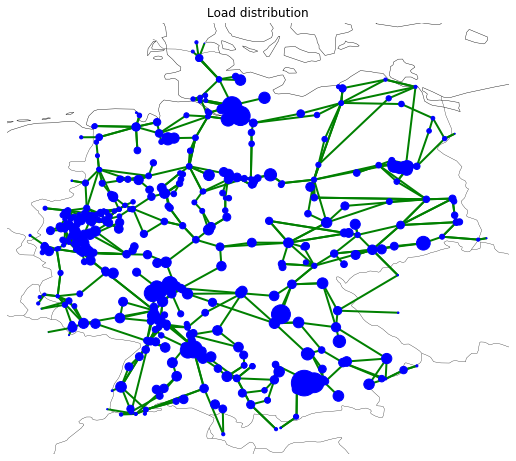

In [100]:
fig,ax = plt.subplots(1,1,subplot_kw={"projection":ccrs.PlateCarree()})

fig.set_size_inches(9,9)

load_distribution = network.loads_t.p_set.loc[network.snapshots[0]].groupby(network.loads.bus).sum()

network.plot(bus_sizes=0.5*load_distribution,ax=ax,title="Load distribution")

In [101]:
fig.tight_layout()
#fig.savefig('load-distribution.png')

In [102]:
network.generators.groupby("carrier")["p_nom"].sum()

carrier
Brown Coal       20879.500000
Gas              23913.130000
Geothermal          31.700000
Hard Coal        25312.600000
Multiple           152.700000
Nuclear          12068.000000
Oil               2710.200000
Other             3027.800000
Run of River      3999.100000
Solar            37041.524779
Storage Hydro     1445.000000
Waste             1645.900000
Wind Offshore     2973.500000
Wind Onshore     37339.895329
Name: p_nom, dtype: float64

In [103]:
network.storage_units.groupby("carrier")["p_nom"].sum()

carrier
Pumped Hydro    9179.5
Name: p_nom, dtype: float64

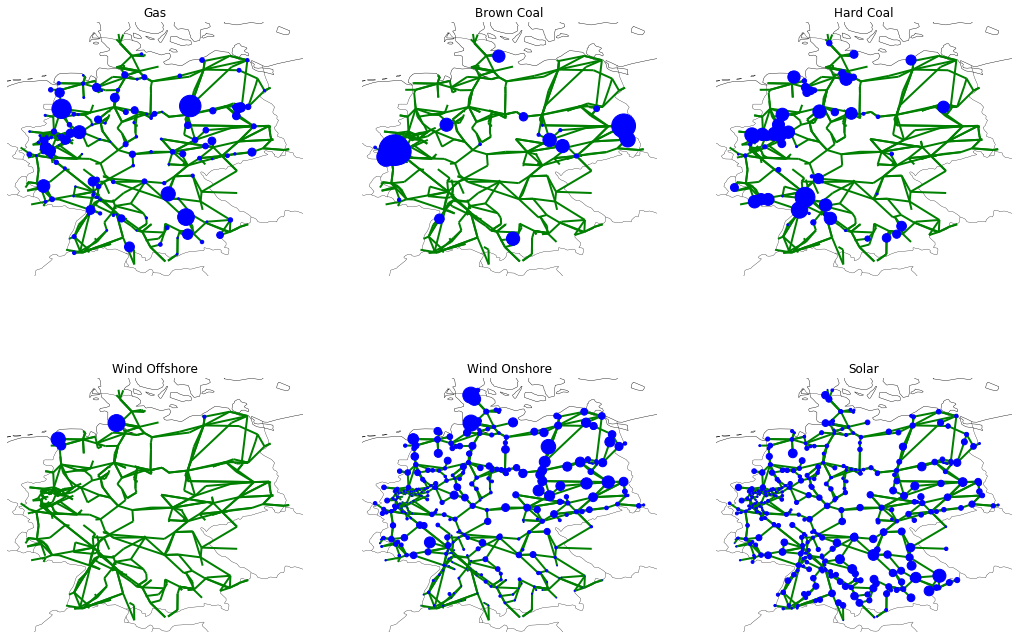

In [155]:
techs = ["Gas","Brown Coal","Hard Coal","Wind Offshore","Wind Onshore","Solar"]

n_graphs = len(techs)

n_cols = 3

if n_graphs % n_cols == 0:
    n_rows = n_graphs // n_cols
else:
    n_rows = n_graphs // n_cols + 1

    
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, subplot_kw={"projection":ccrs.PlateCarree()})

size = 6

fig.set_size_inches(size*n_cols,size*n_rows)

for i,tech in enumerate(techs):
    i_row = i // n_cols
    i_col = i % n_cols
    
    ax = axes[i_row,i_col]
    
    gens = network.generators[network.generators.carrier == tech]
    
    gen_distribution = gens.groupby("bus").sum()["p_nom"].reindex(network.buses.index,fill_value=0.)
    
    network.plot(ax=ax,bus_sizes=0.2*gen_distribution)
    
    ax.set_title(tech)
    
    

## Run Linear Optimal Power Flow on the first day of 2011

In [108]:
#to approximate n-1 security and allow room for reactive power flows,
#don't allow any line to be loaded above 70% of their thermal rating

contingency_factor = 0.7

network.lines.s_max_pu = contingency_factor


In [109]:
#There are some infeasibilities without small extensions                                                                                 
network.lines.loc[["316","527","602"],"s_nom"] = 1715


#the lines to extend to resolve infeasibilities can
#be found by
#uncommenting the lines below to allow the network to be extended

#network.lines["s_nom_original"] = network.lines.s_nom

#network.lines.s_nom_extendable = True
#network.lines.s_nom_min = network.lines.s_nom

#Assume 450 EUR/MVA/km
#network.lines.capital_cost = 450*network.lines.length

In [110]:
group_size = 4

solver_name = "cbc"

print("Performing linear OPF for one day, {} snapshots at a time:".format(group_size))

network.storage_units.state_of_charge_initial = 0.

for i in range(int(24/group_size)):
    #set the initial state of charge based on previous round
    if i>0:
        network.storage_units.state_of_charge_initial = network.storage_units_t.state_of_charge.loc[network.snapshots[group_size*i-1]]
    network.lopf(network.snapshots[group_size*i:group_size*i+group_size],
                 solver_name=solver_name,
                 keep_files=True)
    #network.lines.s_nom = network.lines.s_nom_opt


INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation


Performing linear OPF for one day, 4 snapshots at a time:


INFO:pypsa.opf:Solving model using cbc


Solver log file: '/tmp/tmp3llmuzs8.cbc.log'
Solver solution file: '/tmp/tmphv0eimsd.pyomo.soln'
Solver problem files: ('/tmp/tmphv0eimsd.pyomo.lp',)


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 1449687.25
  Upper bound: 1449687.25
  Number of objectives: 1
  Number of constraints: 11685
  Number of variables: 9941
  Number of nonzeros: 1758
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.31
  Wallclock time: 0.37
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: None
     

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using cbc


Solver log file: '/tmp/tmp9jqzgv6s.cbc.log'
Solver solution file: '/tmp/tmp_0dzhky_.pyomo.soln'
Solver problem files: ('/tmp/tmp_0dzhky_.pyomo.lp',)


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 873763.9023
  Upper bound: 873763.9023
  Number of objectives: 1
  Number of constraints: 11685
  Number of variables: 9941
  Number of nonzeros: 1763
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.36
  Wallclock time: 0.37
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: None
   

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using cbc


Solver log file: '/tmp/tmp29_2xvdl.cbc.log'
Solver solution file: '/tmp/tmpsgidnrjd.pyomo.soln'
Solver problem files: ('/tmp/tmpsgidnrjd.pyomo.lp',)


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 790786.5949
  Upper bound: 790786.5949
  Number of objectives: 1
  Number of constraints: 11685
  Number of variables: 9941
  Number of nonzeros: 1773
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.3
  Wallclock time: 0.34
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: None
    

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using cbc


Solver log file: '/tmp/tmpehve5foh.cbc.log'
Solver solution file: '/tmp/tmp7539c229.pyomo.soln'
Solver problem files: ('/tmp/tmp7539c229.pyomo.lp',)


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 1455232.678
  Upper bound: 1455232.678
  Number of objectives: 1
  Number of constraints: 11685
  Number of variables: 9941
  Number of nonzeros: 1769
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.27
  Wallclock time: 0.31
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: None
   

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using cbc


Solver log file: '/tmp/tmpo4uhu_dt.cbc.log'
Solver solution file: '/tmp/tmpc03mjtqd.pyomo.soln'
Solver problem files: ('/tmp/tmpc03mjtqd.pyomo.lp',)


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 2649026.448
  Upper bound: 2649026.448
  Number of objectives: 1
  Number of constraints: 11685
  Number of variables: 9941
  Number of nonzeros: 1759
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.34
  Wallclock time: 0.38
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: None
   

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using cbc


Solver log file: '/tmp/tmp0lu3gwh5.cbc.log'
Solver solution file: '/tmp/tmpngsnjb41.pyomo.soln'
Solver problem files: ('/tmp/tmpngsnjb41.pyomo.lp',)


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 2142956.889
  Upper bound: 2142956.889
  Number of objectives: 1
  Number of constraints: 11685
  Number of variables: 9941
  Number of nonzeros: 1766
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.39
  Wallclock time: 0.4
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: None
    

In [111]:
#if lines are extended, look at which ones are bigger
#network.lines[["s_nom_original","s_nom"]][abs(network.lines.s_nom - network.lines.s_nom_original) > 1]

In [112]:
p_by_carrier = network.generators_t.p.groupby(network.generators.carrier, axis=1).sum()

In [113]:
p_by_carrier.drop((p_by_carrier.max()[p_by_carrier.max() < 1700.]).index,axis=1,inplace=True)

In [114]:
p_by_carrier.columns

Index(['Brown Coal', 'Gas', 'Hard Coal', 'Nuclear', 'Run of River', 'Solar',
       'Wind Offshore', 'Wind Onshore'],
      dtype='object', name='carrier')

In [115]:
colors = {"Brown Coal" : "brown",
          "Hard Coal" : "k",
          "Nuclear" : "r",
          "Run of River" : "green",
          "Wind Onshore" : "blue",
          "Solar" : "yellow",
          "Wind Offshore" : "cyan",
          "Waste" : "orange",
          "Gas" : "orange"}
#reorder
cols = ["Nuclear","Run of River","Brown Coal","Hard Coal","Gas","Wind Offshore","Wind Onshore","Solar"]
p_by_carrier = p_by_carrier[cols]

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:203: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  "'colors' is being deprecated. Please use 'color'"


Text(0.5, 0, '')

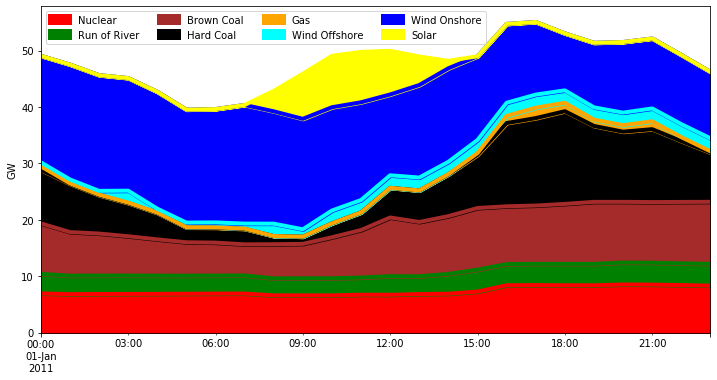

In [117]:
fig,ax = plt.subplots(1,1)

fig.set_size_inches(12,6)

(p_by_carrier/1e3).plot(kind="area",ax=ax,linewidth=4,colors=[colors[col] for col in p_by_carrier.columns])


ax.legend(ncol=4,loc="upper left")

ax.set_ylabel("GW")

ax.set_xlabel("")

In [118]:
fig.tight_layout()
#fig.savefig("stacked-gen.png")

Text(0.5, 0, '')

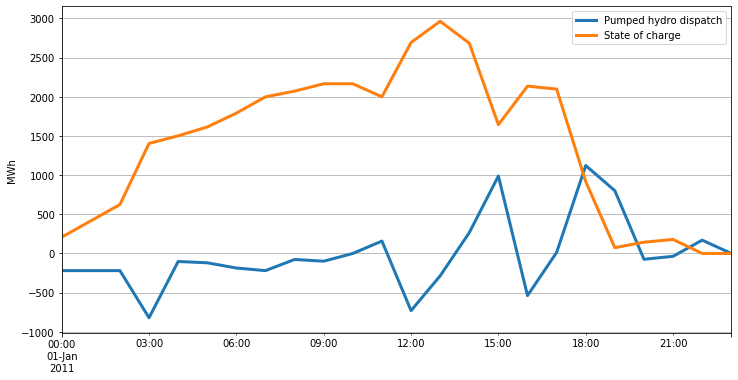

In [119]:
fig,ax = plt.subplots(1,1)
fig.set_size_inches(12,6)

p_storage = network.storage_units_t.p.sum(axis=1)
state_of_charge = network.storage_units_t.state_of_charge.sum(axis=1)
p_storage.plot(label="Pumped hydro dispatch",ax=ax,linewidth=3)
state_of_charge.plot(label="State of charge",ax=ax,linewidth=3)

ax.legend()
ax.grid()
ax.set_ylabel("MWh")
ax.set_xlabel("")

In [120]:
fig.tight_layout()
#fig.savefig("storage-scigrid.png")

In [121]:
now = network.snapshots[4]

In [122]:
print("With the linear load flow, there is the following per unit loading:")
loading = network.lines_t.p0.loc[now]/network.lines.s_nom
print(loading.describe())

With the linear load flow, there is the following per unit loading:
count    852.000000
mean      -0.002552
std        0.259205
min       -0.700000
25%       -0.129689
50%        0.003142
75%        0.121985
max        0.700000
dtype: float64


(<matplotlib.collections.PathCollection at 0x7fe1a9237208>,
 <matplotlib.collections.LineCollection at 0x7fe1a92376a0>)

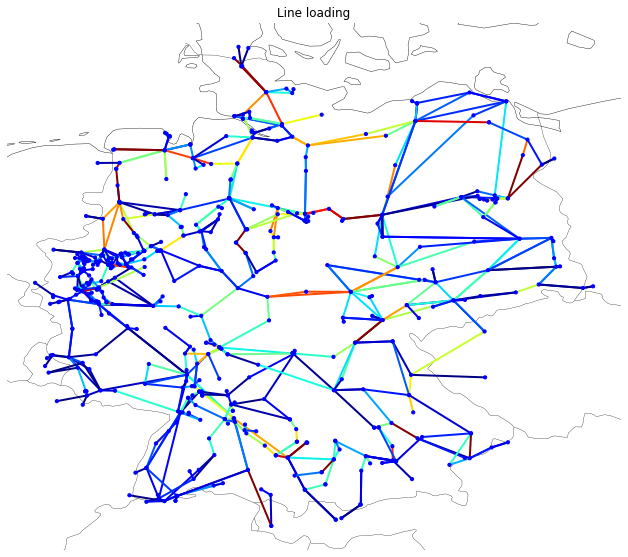

In [153]:
fig,ax = plt.subplots(1,1,subplot_kw={"projection":ccrs.PlateCarree()})
fig.set_size_inches(11,11)

network.plot(ax=ax,line_colors=abs(loading),line_cmap=plt.cm.jet,title="Line loading")

In [25]:
fig.tight_layout()
#fig.savefig("line-loading.png")

In [26]:
network.buses_t.marginal_price.loc[now].describe()

count    585.000000
mean      15.737598
std       10.941995
min      -10.397824
25%        6.992120
50%       15.841190
75%       25.048186
max       52.150120
Name: 2011-01-01 04:00:00, dtype: float64

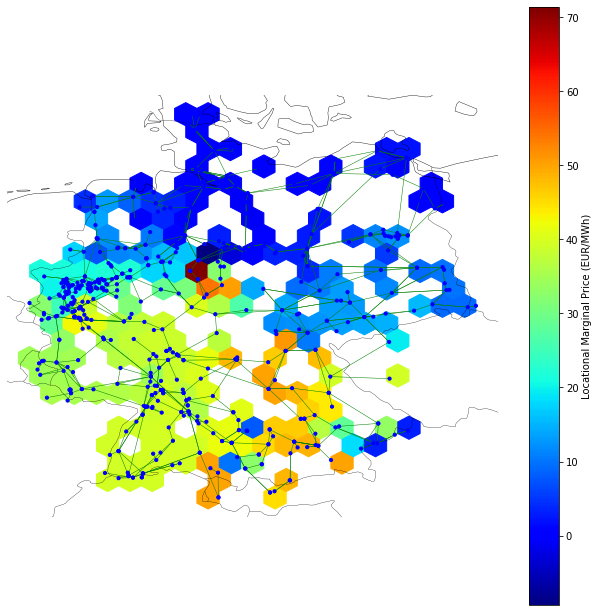

In [152]:
fig,ax = plt.subplots(1,1,subplot_kw={"projection":ccrs.PlateCarree()})
fig.set_size_inches(11,11)


network.plot(ax=ax,line_widths=pd.Series(0.5,network.lines.index))
plt.hexbin(network.buses.x, network.buses.y, 
           gridsize=20,
           C=network.buses_t.marginal_price.loc[now],
           cmap=plt.cm.jet)

#for some reason the colorbar only works with graphs plt.plot
#and must be attached plt.colorbar

cb = plt.colorbar()
cb.set_label('Locational Marginal Price (EUR/MWh)') 


In [128]:
fig.tight_layout()
#fig.savefig('lmp.png')

## Look at variable curtailment

In [129]:
carrier = "Wind Onshore"

capacity = network.generators.groupby("carrier").sum().at[carrier,"p_nom"]

In [130]:
p_available = network.generators_t.p_max_pu.multiply(network.generators["p_nom"])

In [131]:
p_available_by_carrier =p_available.groupby(network.generators.carrier, axis=1).sum()

In [132]:
p_curtailed_by_carrier = p_available_by_carrier - p_by_carrier

In [133]:
p_df = pd.DataFrame({carrier + " available" : p_available_by_carrier[carrier],
                     carrier + " dispatched" : p_by_carrier[carrier],
                     carrier + " curtailed" : p_curtailed_by_carrier[carrier]})

p_df[carrier + " capacity"] = capacity

In [134]:
p_df["Wind Onshore curtailed"][p_df["Wind Onshore curtailed"] < 0.] = 0.

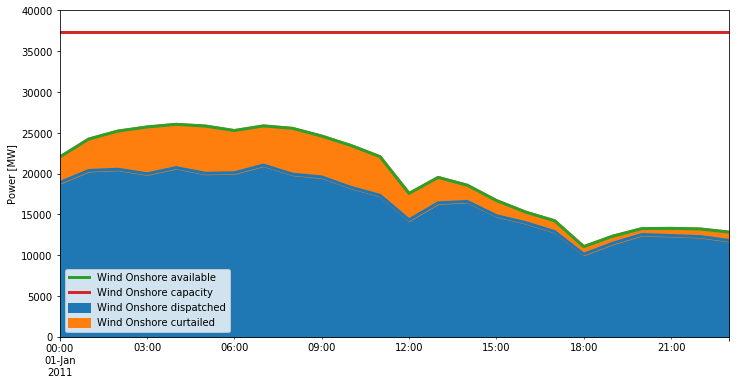

In [135]:
fig,ax = plt.subplots(1,1)
fig.set_size_inches(12,6)
p_df[[carrier + " dispatched",carrier + " curtailed"]].plot(kind="area",ax=ax,linewidth=3)
p_df[[carrier + " available",carrier + " capacity"]].plot(ax=ax,linewidth=3)

ax.set_xlabel("")
ax.set_ylabel("Power [MW]")
ax.set_ylim([0,40000])
ax.legend()

In [136]:
fig.tight_layout()
#fig.savefig("scigrid-curtailment.png")

# Check power flow

In [156]:
now = network.snapshots[0]

In [157]:
for bus in network.buses.index:
    bus_sum = network.buses_t.p.loc[now,bus]
    branches_sum = 0
    for comp in ["lines","transformers"]:
        comps = getattr(network,comp)
        comps_t = getattr(network,comp+"_t")
        branches_sum += comps_t.p0.loc[now,comps.bus0==bus].sum() - comps_t.p0.loc[now,comps.bus1==bus].sum()

    if abs(bus_sum-branches_sum) > 1e-4:
        print(bus,bus_sum,branches_sum)

2 0.0 -0.027589687197973944
3 -40.6136182527 -42.97096328897783
4 -66.7904423051 -72.08103696080457
5 0.0 -9.55667331985751
6 -162.19424032700002 -167.61782833239752
9 -83.63740441590001 -86.30369491517956
10 0.0 -0.009685081349090296
11 53.626476366199995 53.504736062037665
12 0.0 -4.776905548917284
14 -148.260369441 -148.36120768769308
15 0.0 -0.5518874609036217
18 0.0 -9.592557838188782
19 196.07100198400002 194.83511713609585
21 -747.9213700619999 -751.6322984612482
22 0.0 -8.661270843853572
23 -97.92826623309999 -98.75629893761572
25 58.25006774079999 51.63669634545738
26 0.0 -0.004424469029316924
27 -46.25950429609999 -46.506035753511014
29 -62.4029423779 -70.12490700697026
30 0.0 -0.09737744211869881
32 0.0 -64.00366478481968
33 -92.535137725 -106.88977224585744
35 -2.02246482091 -2.022897675619358
36 12.743041939580001 12.74276509137098
38 -158.810154249 -158.96807671253205
39 473.7550291285 465.3684049507194
40 371.2568949478 368.53084498596263
41 945.8289908309999 933.3223203

363 -59.7177958366 -59.72208016774551
364 -159.50722028822 -159.5665660373183
366 -59.4385071655 -65.81744245464051
367 1348.650783503 1348.4018835583233
368 -105.73797674 -105.75931536004288
369 187.2513441025 186.40489782775794
370 116.63291775350001 116.62152203690808
371 -20.6806356874 -20.680768678386286
372 -60.8843822742 -60.887049582768995
373 -281.343405393 -285.05724128355155
374 204.70746792599996 204.51735687435112
375 -119.880333958 -119.9300162415363
376 -52.5463976483 -52.54980182841466
378 547.826293731 547.6252654357477
379 -158.268487905 -158.9744806269451
381 -54.4396543392 -54.54398859661863
383 -157.66195883203562 -157.82845138689063
385 0.0 -0.10716488776546385
386 -46.200473472999995 -46.252213134963284
387 -61.378755044 -61.57894030027422
389 -132.189058399 -132.79523414042012
390 -499.8856921410001 -505.86033335450395
391 0.0 -0.046819622912948944
392 -58.797546409899994 -58.8004295941932
395 -50.46590037200001 -50.48557674533558
398 63.61851296229999 59.208292

## Now perform a full Newton-Raphson power flow on the first hour

In [158]:
#For the PF, set the P to the optimised P
network.generators_t.p_set = network.generators_t.p_set.reindex(columns=network.generators.index)
network.generators_t.p_set = network.generators_t.p

network.storage_units_t.p_set = network.storage_units_t.p_set.reindex(columns=network.storage_units.index)
network.storage_units_t.p_set = network.storage_units_t.p

In [159]:

#set all buses to PV, since we don't know what Q set points are
network.generators.control = "PV"

#set slack
#network.generators.loc["1 Coal","control"] = "Slack"


#Need some PQ buses so that Jacobian doesn't break
f = network.generators[network.generators.bus == "492"]
network.generators.loc[f.index,"control"] = "PQ"

In [160]:

print("Performing non-linear PF on results of LOPF:")

info = network.pf()

Performing non-linear PF on results of LOPF:


INFO:pypsa.pf:Performing non-linear load-flow on AC sub-network SubNetwork 0 for snapshots DatetimeIndex(['2011-01-01 00:00:00', '2011-01-01 01:00:00',
               '2011-01-01 02:00:00', '2011-01-01 03:00:00',
               '2011-01-01 04:00:00', '2011-01-01 05:00:00',
               '2011-01-01 06:00:00', '2011-01-01 07:00:00',
               '2011-01-01 08:00:00', '2011-01-01 09:00:00',
               '2011-01-01 10:00:00', '2011-01-01 11:00:00',
               '2011-01-01 12:00:00', '2011-01-01 13:00:00',
               '2011-01-01 14:00:00', '2011-01-01 15:00:00',
               '2011-01-01 16:00:00', '2011-01-01 17:00:00',
               '2011-01-01 18:00:00', '2011-01-01 19:00:00',
               '2011-01-01 20:00:00', '2011-01-01 21:00:00',
               '2011-01-01 22:00:00', '2011-01-01 23:00:00'],
              dtype='datetime64[ns]', name='name', freq=None)
INFO:pypsa.pf:Newton-Raphson solved in 4 iterations with error of 0.000000 in 0.043101 seconds
INFO:pypsa.pf:Newto

In [161]:
#any failed to converge?
(~info.converged).any().any()

False

In [162]:
print("With the non-linear load flow, there is the following per unit loading\nof the full thermal rating:")
print((network.lines_t.p0.loc[now]/network.lines.s_nom).describe())

With the non-linear load flow, there is the following per unit loading
of the full thermal rating:
count    852.000000
mean      -0.002929
std        0.268129
min       -0.753815
25%       -0.133394
50%        0.003988
75%        0.134928
max        0.832340
dtype: float64


In [163]:
#Get voltage angle differences

df = network.lines.copy()

for b in ["bus0","bus1"]:
    df = pd.merge(df,network.buses_t.v_ang.loc[[now]].T,how="left",
         left_on=b,right_index=True)

s = df[str(now)+"_x"]- df[str(now)+"_y"]

In [164]:
print("The voltage angle differences across the lines have (in degrees):")
print((s*180/np.pi).describe())

The voltage angle differences across the lines have (in degrees):
count    852.000000
mean      -0.055129
std        2.440708
min      -10.918460
25%       -0.504846
50%        0.000848
75%        0.556229
max       17.957528
dtype: float64


(<matplotlib.collections.PathCollection at 0x7fe182e72e10>,
 <matplotlib.collections.LineCollection at 0x7fe1b6e4e160>)

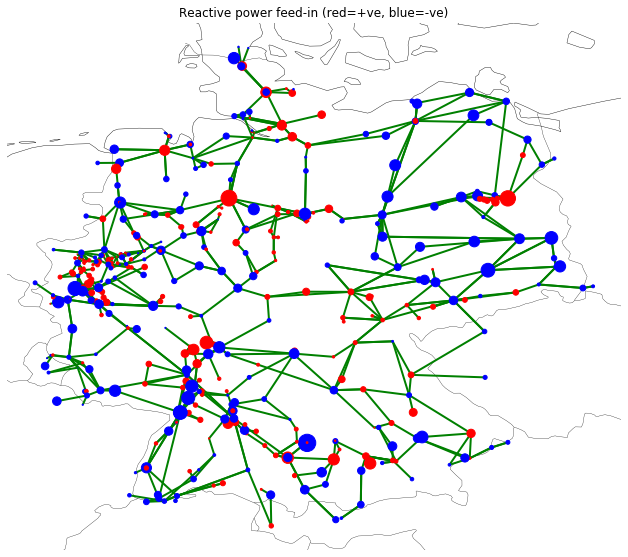

In [165]:
#plot the reactive power

fig,ax = plt.subplots(1,1,subplot_kw={"projection":ccrs.PlateCarree()})

fig.set_size_inches(11,11)

q = network.buses_t.q.loc[now]

bus_colors = pd.Series("r",network.buses.index)
bus_colors[q< 0.] = "b"


network.plot(bus_sizes=abs(q),ax=ax,bus_colors=bus_colors,title="Reactive power feed-in (red=+ve, blue=-ve)")


In [166]:
fig.tight_layout()
#fig.savefig("reactive-power.png")

In [167]:
network.generators_t.q.loc[now].sum()

-4474.210785486167

In [168]:
network.buses_t.q.loc[now].sum()

-4474.210785486168